# Load Dataset

Download 4 files from:
http://yann.lecun.com/exdb/mnist/

In [1]:
import os

In [2]:
path = "/content/drive/My Drive/Colab Notebooks/mnist_from_scratch"
os.listdir(path)

['t10k-labels-idx1-ubyte',
 't10k-images-idx3-ubyte',
 'train-labels-idx1-ubyte',
 'train-images-idx3-ubyte',
 'mnist_from_scratch.ipynb']

In [3]:
# locate files
train_image_source = os.path.join(path, "train-images-idx3-ubyte")
train_label_source = os.path.join(path, "train-labels-idx1-ubyte")
test_image_source = os.path.join(path, "t10k-images-idx3-ubyte")
test_label_source = os.path.join(path, "t10k-labels-idx1-ubyte")

def get_file_stat(source, is_img, desc = None):
  print("==", desc, "==")
  total = os.path.getsize(source)
  header = 16 if is_img else 8
  data_size = total - header
  data_cnt = data_size // 784 if is_img else data_size
  print("TOTAL SIZE: ", total)
  print("HEADER: ", header)
  print("DATA SIZE: ", data_size)
  print("DATA COUNT: ", data_cnt)
  return data_cnt

tr_im_cnt = get_file_stat(train_image_source, 1, "TRAIN_IMAGE")
tr_lb_cnt = get_file_stat(train_label_source, 0, "TRAIN_LABEL")
assert(tr_im_cnt == tr_lb_cnt)

te_im_cnt = get_file_stat(test_image_source, 1, "TEST_IMAGE")
te_lb_cnt = get_file_stat(test_label_source, 0, "TEST_LABEL")
assert(te_im_cnt == te_lb_cnt)

== TRAIN_IMAGE ==
TOTAL SIZE:  47040016
HEADER:  16
DATA SIZE:  47040000
DATA COUNT:  60000
== TRAIN_LABEL ==
TOTAL SIZE:  60008
HEADER:  8
DATA SIZE:  60000
DATA COUNT:  60000
== TEST_IMAGE ==
TOTAL SIZE:  7840016
HEADER:  16
DATA SIZE:  7840000
DATA COUNT:  10000
== TEST_LABEL ==
TOTAL SIZE:  10008
HEADER:  8
DATA SIZE:  10000
DATA COUNT:  10000


In [4]:
import numpy as np
import struct
from array import array
import matplotlib.pyplot as plt

class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):     
        '''
          Read images, labels
        '''
        # labels
        labels = []

        '''
        http://yann.lecun.com/exdb/mnist/, file formats for mnist
        [offset] [type]          [value]          [description]
        0000     32 bit integer  0x00000801(2049) magic number (MSB first)
        0004     32 bit integer  60000            number of items
        0008     unsigned byte   ??               label
        0009     unsigned byte   ??               label
        ........
        xxxx     unsigned byte   ??               label
        '''
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8)) # in Big Endian, read two unsigned ints
            if magic != 2049:
                raise ValueError('Expected 2049, got {}'.format(magic))
            labels = array("B", file.read())

        #images
        '''
        http://yann.lecun.com/exdb/mnist/, file formats for mnist
        [offset] [type]          [value]          [description]
          0000     32 bit integer  0x00000803(2051) magic number
          0004     32 bit integer  60000            number of images
          0008     32 bit integer  28               number of rows
          0012     32 bit integer  28               number of columns
          0016     unsigned byte   ??               pixel
          0017     unsigned byte   ??               pixel
          ........
          xxxx     unsigned byte   ??               pixel
        '''
        with open(images_filepath, 'rb') as file:
          magic, size, rows, cols = struct.unpack(">IIII", file.read(16)) # in Big Endian, read four unsigned ints
          if magic != 2051:
              raise ValueError('Expected 2051, got {}'.format(magic))
          image_data = array("B", file.read())        
        
        images = []
        for i in range(size):
          imsize = rows * cols
          img = np.array(image_data[i * imsize : (i + 1) * imsize])
          img = img.reshape(28, 28, 1)
          images.append(img)
        
        '''
          To numpy
        '''
        images = np.array(images)
        labels = np.eye(10)[np.array(labels).reshape(-1)] # one hot
                   
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)       

In [5]:
mnist_dataloader = MnistDataloader(train_image_source, train_label_source, test_image_source, test_label_source)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

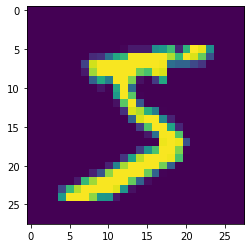

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
plt.imshow(x_train[0].reshape(28, 28))
plt.show()
print(y_train[0])

In [7]:
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))
print(np.shape(y_test))

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


# Split Train/Validation Set

In [8]:
VALIDATION_RATIO = 0.2

val_length = int(len(x_train) * VALIDATION_RATIO)
x_validation = x_train[:val_length]
x_train = x_train[val_length:]
y_validation = y_train[:val_length]
y_train = y_train[val_length:]

print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_validation))
print(np.shape(y_validation))
print(np.shape(x_test))
print(np.shape(y_test))

(48000, 28, 28, 1)
(48000, 10)
(12000, 28, 28, 1)
(12000, 10)
(10000, 28, 28, 1)
(10000, 10)


# Modeling with Keras

## Model Setups

In [9]:
import tensorflow as tf

In [10]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [12]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history = model.fit(
          x_train, 
          y_train, 
          epochs = 100,
          validation_data = (x_validation, y_validation),
          )

Epoch 1/100
1500/1500 [==============================] - 43s 29ms/step - loss: 0.2234 - accuracy: 0.9429 - val_loss: 0.0807 - val_accuracy: 0.9737
Epoch 2/100
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0641 - accuracy: 0.9806 - val_loss: 0.0661 - val_accuracy: 0.9796
Epoch 3/100
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0518 - accuracy: 0.9838 - val_loss: 0.0838 - val_accuracy: 0.9769
Epoch 4/100
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0429 - accuracy: 0.9872 - val_loss: 0.0635 - val_accuracy: 0.9840
Epoch 5/100
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0396 - accuracy: 0.9875 - val_loss: 0.1008 - val_accuracy: 0.9744
Epoch 6/100
1500/1500 [==============================] - 40s 27ms/step - loss: 0.0338 - accuracy: 0.9895 - val_loss: 0.0669 - val_accuracy: 0.9841
Epoch 7/100
1500/1500 [==============================] - 41s 27ms/step - loss: 0.0313 - accuracy: 0.9905 - val_loss: 0

## Visualize Training History

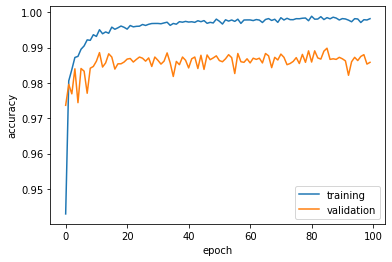

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

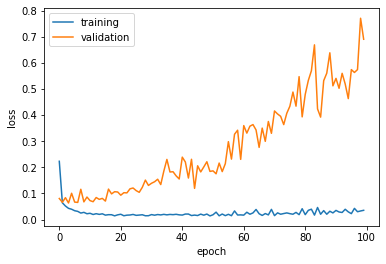

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

## Model Evaluation with Test Dataset

In [16]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.5839 - accuracy: 0.9873


[0.5838727951049805, 0.9872999787330627]

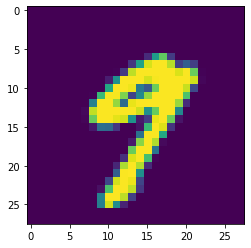

answer:  9
prediction:  9


In [19]:
TCNUM = 20
test_image = x_test[TCNUM].reshape(28, 28)
answer = np.argmax(y_test[TCNUM])
plt.imshow(test_image)
plt.show()

test_image = np.reshape(test_image, (-1, 28, 28, 1))
print("answer: ", answer)
print("prediction: ", np.argmax(model.predict(test_image)))

# Modeling with Torch

## Model Setups

In [20]:
# -*- coding: utf-8 -*-
import torch

In [21]:
# code from torch tutorial
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2) 
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2) 
        )
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
        )

        self.fc1 = torch.nn.Linear(7 * 7 * 64, 64)
        self.fc2 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.permute(0,3,1,2)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [22]:
# modeling
model = Net().to('cpu')
loss_fn = torch.nn.CrossEntropyLoss()

## Training

In [23]:
def get_accuracy(t, v):
  # t : true
  # v : prediction
  assert (len(t) == len(v))
  total = len(t)
  correct = torch.sum(t==v).item()
  accuracy = correct / total
  return accuracy

In [25]:
# training
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
EPOCHS = 100
BATCH_SIZE = 100
TRAIN_STEPS = int(len(x_train) * (1-VALIDATION_RATIO)) // BATCH_SIZE
VALIDATION_STEPS = int(len(x_train) * (VALIDATION_RATIO)) // BATCH_SIZE

for e in range(1,EPOCHS+1):
  #train
  train_acc = 0
  train_loss = 0
  for i in range(TRAIN_STEPS):
    X = torch.as_tensor(x_train[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()
    Y = torch.as_tensor(y_train[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()

    # predict
    y_pred = model(X)
    acc = get_accuracy(torch.argmax(Y, dim = 1), torch.argmax(y_pred, dim = 1))
    train_acc += acc

    # loss
    loss = loss_fn(y_pred, torch.argmax(Y, dim = 1))
    train_loss += loss.item()

    # back propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  
  print("EPOCH {}: accuracy {}% loss {}".format(e, train_acc / TRAIN_STEPS, train_loss / TRAIN_STEPS), end = ' | ')
    
  # validation
  validation_acc = 0
  validation_loss = 0
  with torch.no_grad():
    for i in range(VALIDATION_STEPS):
      X_v = torch.as_tensor(x_validation[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()
      Y_v = torch.as_tensor(y_validation[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()

      # predict
      y_pred = model(X_v)
      acc = get_accuracy(torch.argmax(Y_v, dim = 1), torch.argmax(y_pred, dim = 1))
      validation_acc += acc

      # loss
      loss = loss_fn(y_pred, torch.argmax(Y_v, dim = 1))
      validation_loss += loss.item()

  # report
  print("val_acc {}%  val_loss {} ".format(validation_acc/VALIDATION_STEPS, validation_loss/VALIDATION_STEPS))

EPOCH 1: accuracy 0.9546614583333349% loss 0.16209788745375894 | val_acc 0.9656250000000002%  val_loss 0.1128886064204077 
EPOCH 2: accuracy 0.9720052083333348% loss 0.09147307617725649 | val_acc 0.9645833333333331%  val_loss 0.12978297203759817 
EPOCH 3: accuracy 0.97940104166667% loss 0.067380384951169 | val_acc 0.9692708333333332%  val_loss 0.1135420647939706 
EPOCH 4: accuracy 0.980937500000003% loss 0.06153265781722439 | val_acc 0.9686458333333327%  val_loss 0.12122099376089561 
EPOCH 5: accuracy 0.9841145833333367% loss 0.05216857497953242 | val_acc 0.972708333333333%  val_loss 0.1218388251606181 
EPOCH 6: accuracy 0.9825781250000034% loss 0.056457175660852954 | val_acc 0.9719791666666663%  val_loss 0.12229683584640345 
EPOCH 7: accuracy 0.9854166666666693% loss 0.04717592918298882 | val_acc 0.9760416666666664%  val_loss 0.10767958875112527 
EPOCH 8: accuracy 0.9858072916666698% loss 0.04675776284136646 | val_acc 0.9766666666666662%  val_loss 0.10007874861912569 
EPOCH 9: accurac

## Prediction

In [29]:
# test
test_acc = 0
test_loss = 0
BATCH_SIZE = 100
TEST_STEPS = int(len(x_test)) // BATCH_SIZE
with torch.no_grad():
  for i in range(TEST_STEPS):
    X_t = torch.as_tensor(x_test[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()
    Y_t = torch.as_tensor(y_test[BATCH_SIZE * i: BATCH_SIZE * (i+1)]).float()

    # predict
    y_pred = model(X_t)
    acc = get_accuracy(torch.argmax(Y_t, dim = 1), torch.argmax(y_pred, dim = 1))
    test_acc += acc

    # loss
    loss = loss_fn(y_pred, torch.argmax(Y_t, dim = 1))
    test_loss += loss.item()

In [30]:
# report
print("accuracy {}% loss {}".format(test_acc/TEST_STEPS, test_loss / TEST_STEPS))

accuracy 0.9861999999999995% loss 0.7211516889933214
